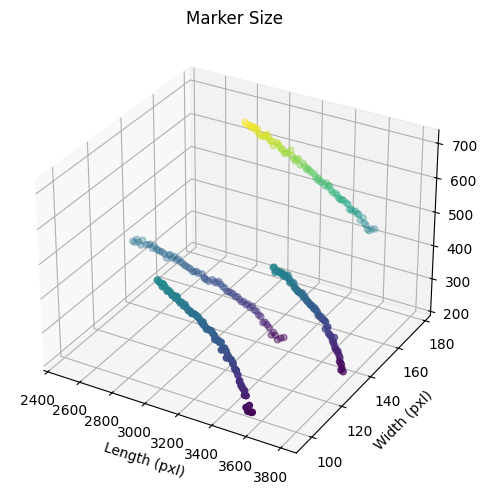

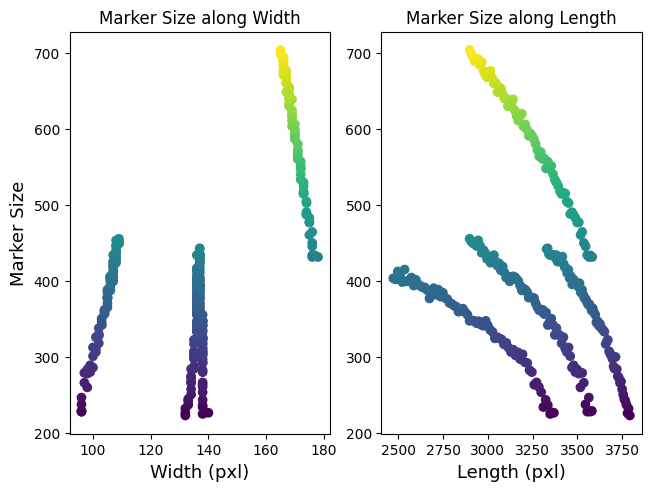

In [ ]:
"""Test if marker recognization is sufficient"""
from pvc_tensile_experiment.Functions import *

# variable inputs
folderName = 'Data/Image Data/PVC P8 Test_0'

# set pixel area limits for the search region and the
# the lower color bound
searchRegion = [60, 4500]
lowerColorLims = [80, 150, 130] # min [80, 80, 100], max [80, 150, 125]

# define the opening kernel and use
kernelSize = 3
useKernel = False

# check the particle areas are increasing and verify if there are abnormal changes to position
MaskCheck(folderName, searchRegion, lowerColorLims, useKernel, kernelSize)


In [ ]:
"""Run the particle tracking, compute strain, and couple stress and strain"""
from pvc_tensile_experiment.Functions import *

# find the tracked particles
tracked = ParticleIdentify(folderName, searchRegion, lowerColorLims, useKernel, kernelSize)

# process the data and compile, getting strain and stress calculations 
# axDist, axStrain, transDist, transStrain, stress  = StrainFunction(folderName, tracked)


In [ ]:
"""Overlay the individual modeling datasets on a plot"""
from pvc_tensile_experiment.Functions import DataReader
import os; import matplotlib.pyplot as plt
import numpy as np

# the desired plasticizer ratio 
plastiRatio = 'P8'

# list the processed file names
fileNames = [i for i in os.listdir('Data/Modeling data') if i.find(f'{plastiRatio}') != -1]

# preallocate the suplots
fig, axs = plt.subplots(1,2, layout = "constrained")
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")

for name in fileNames:
    # read the processed data files 
    axDist, axStrain, transDist, transStrain, stress = DataReader(name)
    
    # find true strain and stress from engineering strain
    stretch = 1 + axStrain
    stressTrue = stress*stretch

    # remove csv from the name
    name = name.removesuffix('.csv').removeprefix('PVC ')

    # plot the engineering axial and transverse strain per frame
    axs[0].plot(axStrain, label = f'{name}')
    axs[1].plot(transStrain, label = f'{name}')
    axs[0].set_title('Axial Strain')
    axs[1].set_title('Transverse Strain')
    axs[0].set_xlabel('Frame')
    axs[1].set_xlabel('Frame')
    axs[0].set_ylabel('Axial Strain')
    axs[1].set_ylabel('Transverse Strain')
    axs[0].legend(fontsize = 7)
    axs[1].legend(fontsize = 7)

    # plot poissons ratio 
    axs1.plot(axStrain, transStrain, label = f'{name}')
    axs1.set_title("Poisson's Ratio")
    axs1.set_xlabel('Axial Strain')
    axs1.set_ylabel('Transverse Strain')
    axs1.legend(fontsize = 7)

    # plot engineering stress-strain and true stress-strain
    axs2[0].plot(axStrain, stress, label = f'{name}')   
    axs2[1].plot(stretch, stressTrue, label = f'{name}')
    axs2[0].set_xlabel('Engineering Strain')
    axs2[1].set_xlabel('Stretch')
    axs2[0].set_ylabel('Engineering Stress (MPa)')
    axs2[1].set_ylabel('True Stress (MPa)')
    axs2[0].set_title('Engineering Stress-Strain')
    axs2[1].set_title('True Stress-Stretch')
    axs2[0].legend(fontsize = 7)
    axs2[1].legend(fontsize = 7)

plt.show()


In [ ]:
"""Overlay the all modeling datasets to compare platicizer"""
from pvc_tensile_experiment.Functions import DataComplile
import matplotlib.pyplot as plt; import numpy as np

# preallocate the suplots
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")
fig, axs3 = plt.subplots(1,1, layout = "constrained")


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # read the processed data files 
    _, axStrain, _, transStrain, stress = DataComplile(plastiRatio)

    # find true strain and stress from engineering strain
    stretch = 1 + axStrain
    stretch2 = 1 + transStrain
    stressTrue = stress*stretch
    
    # define marker size
    size = 3

    # plot poissons ratio 
    axs1.scatter(axStrain, transStrain, label = f'{plastiRatio}', s = size)
    axs1.set_title("Poisson's Ratio", fontsize = 21)
    axs1.set_xlabel('Axial Strain', fontsize = 15)
    axs1.set_ylabel('Transverse Strain', fontsize = 15)
    axs1.legend(fontsize = 15)

    # # plot engineering stress-strain and true stress-strain
    # axs2[0].scatter(axStrain, stress, s = size, label = f'{plastiRatio}')   
    # axs2[1].scatter(stretch, stressTrue, label = f'{plastiRatio}', s = size)
    # axs2[0].set_xlabel('Engineering Strain', fontsize = 15)
    # axs2[1].set_xlabel('Stretch', fontsize = 15)
    # axs2[0].set_ylabel('Engineering Stress (MPa)', fontsize = 15)
    # axs2[1].set_ylabel('True Stress (MPa)', fontsize = 15)
    # axs2[0].set_title('Engineering Stress', fontsize = 21)
    # axs2[1].set_title('True Stress', fontsize = 21)
    # axs2[0].legend(fontsize = 15)
    # axs2[1].legend(fontsize = 15)

    # plot the incompressability conditiion
    axs3.scatter(stretch, -stretch2 + 2, label = f'{plastiRatio} Incompressiblity - Exp', s = 1)
    axs3.set_title("Incompressability Assumption For Uniaxial Test", fontsize = 21)
    axs3.set_xlabel('Axial Stretch', fontsize = 15)
    axs3.set_ylabel('Transverse Stretch', fontsize = 15)

# plot the ideal incompressability condition
stretch = np.arange(1.0, 4.5, 0.01)
axs3.scatter(stretch, np.sqrt(1/stretch), label = 'Incompressiblity - Theoretical', s = 7, c = 'k')
axs3.legend(fontsize = 15)
plt.show()

In [ ]:
"""Combine modeling datasets into one csv"""
from pvc_tensile_experiment.Functions import *; import numpy as np


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = DataComplile(plastiRatio)

    # identify every 25th iteration
    index = np.arange(0, len(stress), 25)

    # use every 25th index and convert stress from MPa to Pa
    transStrain = transStrain[index]
    axStrain = axStrain[index]
    stretch = 1 + axStrain  
    stress = stress[index]

    # save the nominal stress and stretch data 
    df = pd.DataFrame(columns = ["Transverse Strain", "Eng. Axial Strain", "Eng. Stress (Pa)", "Stretch Ratio", "True Stress (Pa)"])
    df["Transverse Strain"] = transStrain
    df["Eng. Axial Strain"] = axStrain
    df["Eng. Stress (Pa)"] = stress    
    df["Stretch Ratio"] = stretch
    df["True Stress (Pa)"] = stress*stretch # conversion for uniaxial engineering stress to true stress
    df.to_csv(f"Data/{plastiRatio} Uniaxial Tensile Data.csv", sep = ',', header = True, index = False)


In [ ]:
"""Elastic modulus and poissons ratio"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# create a dataframe to save the data 
df = pd.DataFrame(columns = ["Plasticizer", "Elastic Modulus (Pa)", "Poissons Ratio", "Bulk Modulus"])
i = 0

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = DataComplile(plastiRatio)

    # define the elastic region
    elasRegion = [list(axStrain).index(i) for i in axStrain if i < 0.35 and i > 0.03]
    elasAxStrain = axStrain[elasRegion]
    elasTransStrain = transStrain[elasRegion]
    elasStress = stress[elasRegion]*1e6

    # curve fit the elastic region. 
    xfit = np.linspace(elasAxStrain[0], elasAxStrain[-1])
    poptE, pcovE = curve_fit(LinearFit, elasAxStrain, elasStress)
    poptP, pcovP = curve_fit(LinearFit, elasAxStrain, elasTransStrain)
    print(f'{plastiRatio} Elastic Modulus (Pa): {poptE}, Poissons Ratio: {poptP},  {poptE[0]/2/(1 - 2*poptP[0])}')

    # plot engineering stress vs strain
    plt.figure(0)
    plt.scatter(elasAxStrain, elasStress)
    plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'r')
    plt.xlabel('Axial Strain')
    plt.ylabel('Stress (Pa)')
    plt.title(f'{plastiRatio} Elastic Modulus (Pa)')
    plt.show()

    # plot poissons ratio
    plt.figure(1)
    plt.scatter(elasAxStrain, elasTransStrain)
    plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'r')
    plt.xlabel('Axial Strain')
    plt.ylabel('Transverse Strain')
    plt.title(f'{plastiRatio} Poissons Ratio')
    plt.show()  

    df.loc[i] = [plastiRatio, poptE[0], poptP[0], poptE[0]/2/(1 - 2*poptP[0])]
    i = i + 1
   

# df.to_csv(f"Data/PVC Gel Material Parameters.csv", sep = ',', header = True, index = False)

In [ ]:
"""Absolute strain from Zach's electrostatic adheasion data"""

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Data/PVC Gel Material Parameters.csv')

# Zachs data was recorded at 1500V/mm E field with stress in mN/cm^2.
maxElectrostaticStress = [2000, 1750, 1250, 1500]

# convert from mN/cm^2. 1 mN/cm^2 = 10 pascals
maxElectrostaticStress = [i*10 for i in maxElectrostaticStress]
strain = []

# estimate the strain from the elastic modulus and max electrostatic stress
for i in range(0, len(maxElectrostaticStress)):
    strain.append(maxElectrostaticStress[i]/data["Elastic Modulus (Pa)"][i])

name = ['P2', 'P4', 'P6', 'P8']
for i in range(0, len(maxElectrostaticStress)):
    plt.scatter(strain[i], maxElectrostaticStress[i], label = f'{name[i]}')

plt.xlabel('Strain')
plt.ylabel('Adheasion Stress (Pa)')
plt.title('Maximum Strain in a Linear Actuator')
plt.legend()
plt.show()

# Zach's data looks at round cut PVC gels where the electrode takes up all the 
# area of the gel. in the EPIC, the electrode compresses the fluid towards the 
# center, where there's significantly more gel material. this means for the 
# given force, the pressure is significantly lowered as there is more area to 
# consider. this relationship is the absolulte maximum potential 

The curve fitment below was written when we thought that the gels were stretched into hyperelasticity.

In [ ]:
"""Nominal Engineering-Stretch Hyperelastic Model Fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define the plasticizer ration we want
plastiRatio = 'P2'

# compile all the data  
_, axStrain, _, _, stress = DataComplile(plastiRatio)

# convert from engineering measurements to true measurements
stretch = 1 + axStrain
stress = stress*1e6

# Define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch - 1/stretch**2)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch - 1/stretch**2)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch - 1/stretch**2)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha - 1) - stretch**(-alpha/2 - 1)) + 2*mu1/alpha1*(stretch**(alpha1 - 1) - stretch**(-alpha1/2 - 1)) + 2*mu2/alpha2*(stretch**(alpha2 - 1) - stretch**(-alpha2/2 - 1))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch - 1/stretch**2)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch - 1/stretch**2)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# Define fitting function
def FitModel(model, stretch, stress, paramGuess):
    def residuals(params):
        return model(params, stretch) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# Models and initial guesses
models = {
    "Neo-Hookean": (NeoHookean, [1.0e6]),
    "Mooney-Rivlin": (MooneyRivlin, [1.0e6, 0.1e6]),
    "Yeoh": (Yeoh, [1.0e6, -0.1e4, 0.01e2]),
    "Gent": (Gent, [1.0e1, 100e6]),
    # "Arruda-Boyce": (EightChain, [1.0, 10]),
    "Ogden": (Ogden, [10.0e4, 1.0, -7.0e4, 2.0,  5.0e4, 2.0]),
    "ExtendedTube": (ExtendedTube, [1.0e6, 1.0e6, 0.7, 0.1])
}

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, stretch, stress, guess)
    predictedStress = model(params, stretch)
    r2 = RSquared(stress, predictedStress)
    fitResults[name] = (params, r2)

# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(stretch, stress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(stretch, models[name][0](params, stretch), label = name, linewidth = 2, linestyle = 'dotted')

plt.xlabel("Stretch Ratio")
plt.ylabel("Nominal Stress (MPa)")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()


In [ ]:
"""Nominal Engineering-Stretch Hyperelastic Model Fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define the plasticizer ration we want
plastiRatio = 'P2'

# compile all the data  
_, axStrain, _, _, stress = DataComplile(plastiRatio)

# convert from engineering measurements to true measurements
stretch = 1 + axStrain
stress = stress*1e6

# Define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch - 1/stretch**2)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch - 1/stretch**2)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch - 1/stretch**2)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha - 1) - stretch**(-alpha/2 - 1)) + 2*mu1/alpha1*(stretch**(alpha1 - 1) - stretch**(-alpha1/2 - 1)) + 2*mu2/alpha2*(stretch**(alpha2 - 1) - stretch**(-alpha2/2 - 1))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch - 1/stretch**2)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch - 1/stretch**2)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# Define fitting function
def FitModel(model, stretch, stress, paramGuess):
    def residuals(params):
        return model(params, stretch) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# Models and initial guesses
models = {
    "Neo-Hookean": (NeoHookean, [1.0e6]),
    "Mooney-Rivlin": (MooneyRivlin, [1.0e6, 0.1e6]),
    "Yeoh": (Yeoh, [1.0e6, -0.1e4, 0.01e2]),
    "Gent": (Gent, [1.0e1, 100e6]),
    # "Arruda-Boyce": (EightChain, [1.0, 10]),
    "Ogden": (Ogden, [10.0e4, 1.0, -7.0e4, 2.0,  5.0e4, 2.0]),
    "ExtendedTube": (ExtendedTube, [1.0e6, 1.0e6, 0.7, 0.1])
}

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, stretch, stress, guess)
    predictedStress = model(params, stretch)
    r2 = RSquared(stress, predictedStress)
    fitResults[name] = (params, r2)

# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(stretch, stress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(stretch, models[name][0](params, stretch), label = name, linewidth = 2, linestyle = 'dotted')

plt.xlabel("Stretch Ratio")
plt.ylabel("Nominal Stress (MPa)")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()


In [ ]:
"""Cross link fitment"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Constants for PVC Polymer
R = 8.314  # Universal gas constant (J/mol·K)
T = 0  # Room temperature (K)
nu = 5e-6  # Cross-link density (mol/cm³)
Mc = 30000  # Molecular weight between cross-links (g/mol)

# Engineering stress-strain data (Replace with real experimental data)
engineering_strain = axStrain
engineering_stress = stress

# Convert engineering to true stress and strain
trueStrain = np.log(1 + engineering_strain)
trueStress = engineering_stress * (1 + engineering_strain)

# Define the modified Yeoh model function
def modified_yeoh(I1, C1, C2, C3):
    additional_term = (nu * R * T / Mc) * (I1 - 3)  # Cross-link effect
    return C1 * (I1 - 3) + C2 * (I1 - 3)**2 + C3 * (I1 - 3)**3 + additional_term

# Function to fit true stress-strain data using Yeoh model
def fit_yeoh(trueStrain, trueStress):
    I1 = 2 * (trueStrain + 1)  # First invariant approximation for uniaxial tension
    
    def objective(params):
        C1, C2, C3 = params
        return modified_yeoh(I1, C1, C2, C3) - trueStress
    
    initial_guess = [0.20409796, -0.00736779,  0.00022124]  # Initial parameter estimates
    params_opt, _ = opt.least_squares(objective, initial_guess).x, None
    
    # Compute R-squared value
    fitted_stress = modified_yeoh(I1, *params_opt)
    ssResidual = np.sum((trueStress - fitted_stress) ** 2)
    ssTotal = np.sum((trueStress - np.mean(trueStress)) ** 2)
    r_squared = 1 - (ssResidual / ssTotal)
    
    return params_opt, r_squared, fitted_stress

# Fit the model
params_opt, r_squared, fitted_stress = fit_yeoh(trueStrain, trueStress)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(trueStrain, trueStress, label='True Stress Data', color='blue')
plt.plot(trueStrain, fitted_stress, label=f'Modified Yeoh Fit (R²={r_squared:.4f})', color='red')
plt.xlabel('True Strain')
plt.ylabel('True Stress (MPa)')
plt.legend()
plt.title('Curve Fitting with Modified Yeoh Model for Over-Plasticized PVC')
plt.show()

# Print optimized parameters
print(f"Optimized C1: {params_opt[0]:.4f}, C2: {params_opt[1]:.4f}, C3: {params_opt[2]:.4f}")
print(f"R-squared: {r_squared:.4f}")
